# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: A. Gramfort, M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal coordinate descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 29th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 23 novembre 2020**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Theo"
ln1 = "Jolivet"
fn2 = "Manon"
ln2 = "Verbockhaven"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_jolivet_theo_and_verbockhaven_manon.ipynb


In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
# the usual functions:

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b

## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$


<div class="alert alert-success">
    <b>QUESTION 1:</b> We ask you to code
     <ul>
         <li>cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$</li>
         <li>greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.
</li>
    </ul>
</div>

**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [4]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [5]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    w = np.zeros(n_features)
    residuals = b - A.dot(w)

    lips_const = np.linalg.norm(A, axis=0) ** 2

    
    for t in range(n_iter):
        j = t % n_features
        old_w_j = w[j]
        w[j] = w[j] + A[:,j].T@residuals/lips_const[j]
        residuals = residuals + (old_w_j - w[j])* A[:,j]                     
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    indice_decr = np.argsort(np.abs(gradient))
    lips_const = np.linalg.norm(A, axis=0) ** 2
    residuals = b - A.dot(w)
    l_indice = list(np.argsort(np.abs(gradient)))
    
    for t in range(n_iter):
        j = l_indice[-1]
        old_w_j = w[j]
        w[j] = w[j] + A[:,j].T@residuals/lips_const[j]
        residuals = residuals + (old_w_j - w[j])* A[:,j]
        gradient = gradient + gram[:,j]*(w[j] - old_w_j)
        l = 0
        while l < len(gradient) and np.abs(gradient[j]) > np.abs(gradient[l]) :
            l = l + 1
        l_indice.insert(l,j)
        l_indice.pop(-1)
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

In [6]:
np.array([1, 2]) - 1

array([0, 1])

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Compute a precise minimum with your favorite solver</li>
         <li>Compare the performance of cyclic and greedy CD as function of iterations.</li>
         <li>From a practical point of view, could you use greedy CD for L2 regularized logistic regression? to solve OLS, but with 100,000 features? Explain your answers.</li>
    </ul>
</div>

**Remark:** You will do the plots using the number of iterations on the x-axis and not time as your code is likely to be slow unless you use [numba](https://numba.pydata.org/).

2900.8594519338762


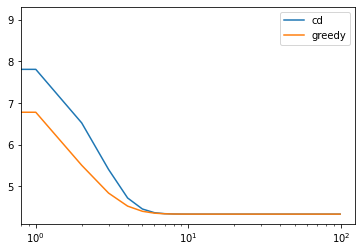

In [7]:
import matplotlib.pyplot as plt
w_star = np.linalg.inv(A.T@A)@A.T@b

w_cd ,lent_cd =cyclic_cd(A, b, len(b)*10)
w_greed, lent_greed = greedy_cd(A, b, len(b)*10)

print(np.linalg.norm(b - A.dot(w_star)**2/2))
plt.plot(np.log(lent_cd / np.log(np.linalg.norm(b - A.dot(w_star))**2/2)), label = 'cd')
plt.plot(np.log(lent_greed / np.log(np.linalg.norm(b - A.dot(w_star))**2/2)), label = 'greedy')
plt.legend()
plt.xscale('log')


When the amount of feature is important, comparing the absolute value of the gradient is O(n) where n is the amount of features.)

## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$

<div class="alert alert-success">
    <b>QUESTION 3:</b><br/>
    Assuming uniqueness of the solution, show that: $\lambda \geq \lambda_{max} \Leftrightarrow \hat w = 0$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.
</div>

**HINT:** You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert (w_1)  \times \dots \times \partial \vert \cdot \vert (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert (w_j) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

$$\partial f(w) = \sum \frac{-y_i x_i \exp(-y_i w_T x_i)}{1 + y_i x_i \exp(-y_i w_T x_i)} + \lambda z $$ with $$ z \in \partial |.|(\hat w) $$
$$ \partial f(\hat w) = 0 \Leftrightarrow \sum \frac{y_i x_i \exp(-y_i w_T x_i)}{1 + y_i x_i \exp(-y_i w_T x_i)} = \lambda z $$
$$ \hat w = 0 \Rightarrow \lambda z = \sum \frac{y_i x_i}{2}, z_i \in [-1, 1] \Rightarrow \lambda \geq \lambda max(|z_i|, i \in 1, ...n) = \frac 12 \Vert X^\top y \Vert_{\infty} = \lambda_{max} $$
So $$\hat w = 0 \Rightarrow \lambda \geq \lambda_{max}$$
We have to show that  $$ \hat w \ne 0 \Rightarrow \lambda < \lambda_{max}$$
$$ \hat w \ne 0 \Rightarrow z_i \in {-1, 1} \Rightarrow \lambda z = \frac 12 \Vert X^\top \hat y \Vert_{\infty}$$ with $$\hat y_i = y_i \frac{\exp(-y_i w^T x_i)}{1 + \exp(-y_i w^T x_i)}$$
We notice that $$\hat w \ne 0 \Rightarrow \frac 12 \Vert X^\top y \Vert_{\infty} > \frac 12 \Vert X^\top \hat y \Vert_{\infty} $$
To conclude $$ \lambda =  \frac 12 \Vert X^\top \hat y \Vert_{\infty} < \frac 12 \Vert X^\top y \Vert_{\infty} = \lambda_{max} $$

<div class="alert alert-success">
    <b>QUESTION 4:</b><br/>
    Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.
</div>

$$ \frac{\partial F}{\partial w_k}  = \sum \frac{-y_ix_i^k \exp(-yiw^Tx_i)}{1 + \exp(-yiw^Tx_i)}$$
As seen in th previous classes (convexity smoothness exercice 5):
$$g(\alpha) = \frac{\exp(\alpha)}{1 + \exp(\alpha)} \Rightarrow g'(\alpha) \leq \frac{1}{4} \forall \alpha
$$
Then $$ || \frac{\partial F}{\partial w_k} (x) - \frac{\partial F}{\partial w_k} (y) || = \sum (y_i x_i^k)^2 \frac{1}{4} = \sum (x_i^k)^2 \frac{1}{4} = \frac{||X_k||^2}{4}$$ 

<div class="alert alert-success">
    <b>QUESTION 5:</b><br/>
    Code cyclic proximal coordinate descent for sparse Logistic regression:
</div>

**WARNING**: the Lasso means linear regression (quadratic fitting term) with L1 penalty. Sparse logistic regression means logistic regression with L1 penalty.

In [8]:
np.linalg.norm(np.array([[1, 2], [3, 4]]), axis = 0)**2

array([10., 20.])

In [9]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 20.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.sign(x) * np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    lips_const = np.linalg.norm(X, axis = 0)**2/4
    all_objs = []
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            grad_j = sum( -y[i]*X[i, j]*np.exp(-y[i]*Xw[i]) /(1 + np.exp(-y[i]*Xw[i])) for i in range(len(w)))
            w[j] = soft_thresh(w[j] - grad_j/lips_const[j] , lamb/ lips_const[j])
            
            if old_w_j != w[j]:
                 Xw = Xw + X[:,j]*(w[j] - old_w_j) 
        all_objs.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
    return w, all_objs

In [10]:
w_log, all_objs = cd_logreg(X, y, lamb, 200)

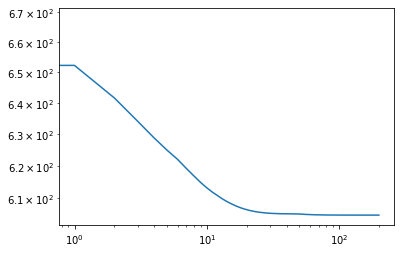

In [11]:
plt.plot(np.array(all_objs))
plt.yscale('log')
plt.xscale('log')

# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

In [12]:
from sklearn.datasets import fetch_openml

leuk = fetch_openml("leukemia")

X = np.asfortranarray(leuk.data)
y = np.ones(leuk.target.shape)
y[leuk.target == leuk.target[0]] = -1.

In [13]:
print(X.shape)

lambda_max_lasso = norm(X.T.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

(72, 7129)


<div class="alert alert-success">
    <b>QUESTION 6:</b> Code
    <ul>
        <li>a simple proximal gradient solver for the Lasso</li>
        <li>a prox CD solver for the Lasso and compare them on this dataset.</li>
    </ul>
</div>

**Remark:** Do the plots in terms of epochs, not updates (to be fair to CD).

In [19]:
def PGD(X, y, lamb, n_iter) :
    w = np.zeros(len(X[0]))
    all_objs = []
    L = (np.linalg.norm(X, axis = 0)**2).sum()
    Xw = X.dot(w)
    for t in range(n_iter) :
        grad = sum(-y[i] * X[i] * np.exp(-y[i] * Xw[i])/(1 + np.exp(-y[i] * Xw[i])) for i in range(len(X)))
        w = soft_thresh(w - grad/L, lamb/L)
        Xw = X.dot(w)
        all_objs.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    return(w, all_objs)

def cd_logreg_compare (X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    lips_const = np.linalg.norm(X, axis = 0)**2/4
    all_objs = []
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            grad_j = sum( -y[i]*X[i, j]*np.exp(-y[i]*Xw[i]) /(1 + np.exp(-y[i]*Xw[i])) for i in range(len(Xw)))
            w[j] = soft_thresh(w[j] - grad_j/lips_const[j] , lamb/ lips_const[j])
            if old_w_j != w[j]:
                Xw = Xw + X[:,j]*(w[j] - old_w_j) 
        all_objs.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
        if int(t/5)*5 == t : 
            print('je réfléchie')
        elif int(t/8)*8 :
            print('tic tac tic tac')
    return w, all_objs

In [25]:
w_PGD, all_objs_PGD = PGD(X, y, lambd, 500)

In [27]:
w_cd, all_objs_cd = cd_logreg_compare (X, y, lambd, 5)

je réfléchie


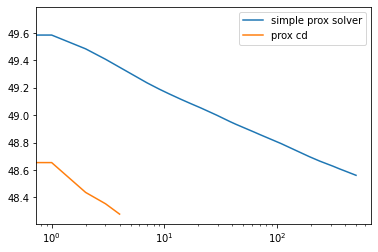

In [28]:
plt.plot(np.array(all_objs_PGD), label = 'simple prox solver')
plt.plot(np.array(all_objs_cd), label = 'prox cd')
plt.xscale('log')
plt.legend()

We notice that PGD needs much more epochs to converge in comparison with cd_log.